For the video style transfer, I used the trained model from Dumoulin V2, which works with **unseen style images**. I applied **style transfer** to each frame of the video individually, using the model to generate stylized versions of the frames while maintaining the content of the video. By applying the trained model frame by frame, I ensured that the video retained its original structure and flow, while each frame reflected the artistic style of the chosen reference image. So, the first part of the notebook will be the same as dumoulin_v2.


## Import libraries

This section imports the necessary libraries for image processing, neural style transfer, and evaluation.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from pathlib import Path
from PIL import Image
from torch.optim import Adam
import pandas as pd
import time
from skimage.metrics import structural_similarity as ssim
import numpy as np
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, zoom
from scipy.stats import entropy
from PIL import Image as PILImage
import lpips
import cv2
from PIL import Image
import imageio 

## Neural Style Transfer with ADAIN (Dumoulin V2)

This code implements a **Neural Style Transfer (NST)** model based on an enhanced version of **Dumoulin et al. (2017)**, utilizing **Adaptive Instance Normalization (ADAIN)** to dynamically apply **any unseen style** to the content image. This approach eliminates the need for predefined **style codes** and instead directly uses the style image path to extract style features at runtime. ADAIN helps modulate the normalization process using the style statistics, offering a more flexible and efficient style transfer compared to the original approach.

### Key Components:

#### 1. **Image Style Transfer Network (`ImageStyleTransferNet`)**
**Architecture**: The model uses a **convolutional neural network (CNN)** with the following components:

- **Down-sampling**: Reduces the image's spatial dimensions using convolutional layers, capturing deeper image features.
- **Residual Blocks**: Contains **residual blocks** that enable the model to effectively learn complex transformations while preserving important content details.
- **Upsampling**: After down-sampling, the image is upsampled to its original size, ensuring high-quality output with preserved details.

**Objective**: To generate an image that contains the content of one image and the style of another, with the style dynamically extracted from the provided style image using ADAIN.

#### 2. **Adaptive Instance Normalization (ADAIN)**
The core difference in this version is the use of **ADAIN**, which replaces the fixed style codes from the original model with **style statistics** (mean and standard deviation) that are extracted from the provided style image:

**Style Extraction**: The style statistics are dynamically computed from the style image using the **VGG16** model.

**Style Modulation**: These statistics are used to modulate the normalization process at each layer, allowing the model to apply the style to the content image in a more flexible manner.

#### 3. **Style Parameter Generation (`StyleParameterGenerator`)**
Instead of using predefined style codes, this version uses **ADAIN** to generate **style parameters** based on the extracted statistics from the style image:

**Style Parameters**: The mean and standard deviation values are extracted from the style image using **VGG16** and used to modulate the normalization process during the forward pass.

**Dynamic Style Handling**: This approach allows the model to handle any unseen style by simply providing the path of the style image, making it much more versatile than the original model.

#### 4. **Convolution with CIN (`ConvolutionWithCIN`)**
Each convolutional layer applies **Conditional Instance Normalization (CIN)**, where the **scale** and **shift** parameters are dynamically adjusted based on the style statistics of the current style image:

**Normalization**: The input feature maps are normalized using **Instance Normalization**.

**Style Modulation**: The **style parameters** generated from the style image (mean and standard deviation) are used to modulate the normalization at each layer, applying the style to the content image.

#### 5. **Loss Functions**
The loss functions remain similar to the original Dumoulin approach but are now applied based on the dynamically extracted style:

**Content Loss**: Measures the difference between the content of the content image and the generated image using **Mean Squared Error (MSE)** between feature maps.

**Style Loss**: Measures the difference between the style of the reference style image and the generated image by comparing their **Gram matrices**.

**Total Variation (TV) Loss**: Encourages spatial smoothness in the generated image and reduces high-frequency noise.

#### 6. **Training Loop**
The model is trained iteratively with the following steps:

**Content and Style Images**: The content image is passed through the model, and the style image path is provided at runtime.

**Style Statistics Extraction**: Style statistics (mean and standard deviation) are dynamically extracted from the style image.

**Optimization**: The **Adam optimizer** is used to minimize the total loss, which includes content, style, and TV losses.

The model learns to apply the style of the style image to the content image, improving the quality of the generated image over time.

#### 7. **Model Checkpoints and Results**
The model saves **checkpoints** during training, which allows for recovery or further training. Stylized images are displayed periodically to monitor the progress of the style transfer.

#### 8. **Dataset and Image Processing**
The **CustomImageDataset** class loads content and style images from the specified directories. The **CustomDataProcessor** class applies necessary transformations such as resizing, cropping, and normalization to prepare the images for input to the model.

### Training Process:
**Dataset**: Both content and style images are loaded, and the model is trained to apply the style of the given style image to the content image.

**Style Statistics**: The **VGG16 model** is used to extract style statistics from the style image, which are used to modulate the network’s layers using **ADAIN**.

**Loss Calculation**: During each training iteration, content, style, and TV losses are computed and used to update the model’s parameters.

### Differences from Dumoulin et al. (2017):

**Style Code Removal**: The major change in this version is the removal of the **style code**. Instead of using predefined style codes, the model directly takes the **path of a style image** and dynamically extracts the style statistics (mean and standard deviation) from the image to apply its style to the content.

**ADAIN for Style Modulation**: The use of **Adaptive Instance Normalization (ADAIN)** allows the model to **adapt to any unseen style** by extracting the style statistics directly from the provided style image, enabling more flexible and efficient style transfer.

### Usage:
This model allows for experimenting with **content images** and **style images**, offering greater flexibility in style transfer. Hyperparameters like **content weight**, **style weight**, and **TV weight** can be adjusted to fine-tune the results. The final model and loss logs are saved for further analysis and refinement.


In [2]:
# --- Loss Functions ---
def calculate_content_loss(feature_maps, targets, layers):
    # Calculate content loss using Mean Squared Error (MSE) between the feature maps of two images at specified layers
    loss_val = 0
    for layer in layers:
        loss_val += torch.nn.functional.mse_loss(feature_maps[layer], targets[layer])  # MSE loss between feature maps
    return loss_val

def create_gram_matrix(tensor_input):
    # Create a Gram matrix from the given input tensor, which captures style information for each layer
    batch_size, channels, height, width = tensor_input.size()
    features = tensor_input.flatten(2)  # Flatten the tensor
    gram_matrix = torch.bmm(features, features.transpose(1, 2))  # Compute the Gram matrix
    return gram_matrix.div(height * width)  # Normalize the Gram matrix by the spatial dimensions

def calculate_style_loss(feature_maps, targets, layers):
    # Calculate the style loss between two images using the Gram matrices of their feature maps
    style_loss_val = 0
    for layer in layers:
        style_loss_val += torch.nn.functional.mse_loss(create_gram_matrix(feature_maps[layer]), 
                                                      create_gram_matrix(targets[layer]))  # MSE loss for style
    return style_loss_val

def calculate_total_variation_loss(input_tensor):
    # Calculate the total variation loss, which encourages spatial smoothness in the image
    tv_loss = torch.mean(torch.abs(input_tensor[:, :, :, :-1] - input_tensor[:, :, :, 1:]))  # Horizontal difference
    tv_loss += torch.mean(torch.abs(input_tensor[:, :, :-1, :] - input_tensor[:, :, 1:, :]))  # Vertical difference
    return tv_loss

# --- Normalization Constants ---
NORMALIZATION_MEAN = (0.485, 0.456, 0.406)
NORMALIZATION_STD = (0.229, 0.224, 0.225)

# Normalize and denormalize images to match the VGG16 model's input requirements
image_normalize = T.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD)
image_denormalize = T.Normalize(mean=[-m / s for m, s in zip(NORMALIZATION_MEAN, NORMALIZATION_STD)],
                                 std=[1 / s for s in NORMALIZATION_STD])

# --- Image Preprocessing ---
def get_image_transforms(image_size=None, crop_size=None, center_crop_flag=False):
    # Get a composition of image transformations (resize, crop, and normalization)
    transform_list = []
    if image_size:
        transform_list.append(T.Resize(image_size))  # Resize the image to the specified size
    if crop_size:
        if center_crop_flag:
            transform_list.append(T.CenterCrop(crop_size))  # Center crop if flag is true
        else:
            transform_list.append(T.RandomCrop(crop_size))  # Random crop otherwise
    transform_list.append(T.ToTensor())  # Convert image to tensor
    transform_list.append(image_normalize)  # Normalize the image
    return T.Compose(transform_list)  # Return the composed transformation

def load_image_from_path(path, image_size=None, crop_size=None, center_crop_flag=False):
    # Load an image from the given path and apply necessary transformations
    transforms = get_image_transforms(image_size=image_size, crop_size=crop_size, center_crop_flag=center_crop_flag)
    image = Image.open(path).convert("RGB")  # Open the image and convert to RGB
    return transforms(image).unsqueeze(0)  # Apply transformations and add batch dimension

def save_image_to_path(image, save_path):
    # Denormalize the image and save it to the specified path
    image = image_denormalize(torchvision.utils.make_grid(image)).clamp_(0.0, 1.0)  # Denormalize and clamp to [0, 1]
    torchvision.utils.save_image(image, save_path)  # Save the image to the given path
    return None

# --- Custom Dataset Class ---
class CustomImageDataset:
    def __init__(self, directory_path, max_images=None):
        # Initialize the dataset by loading all images from the given directory
        self.image_files = sorted(list(Path(directory_path).glob('*.jpg')))  # Get all .jpg images
        if max_images is not None:
            self.image_files = self.image_files[:max_images]  # Limit the number of images if max_images is specified
        if len(self.image_files) == 0:
            raise ValueError("No images found in the provided directory.")  # Raise error if no images are found
        if len(self.image_files) == 1:
            print("Single content image found, proceeding with that image.")  # Warn if only one image is found

    def __len__(self):
        return len(self.image_files)  # Return the number of images in the dataset

    def __getitem__(self, index):
        img = Image.open(self.image_files[index]).convert('RGB')  # Open the image and convert to RGB
        return img, index  # Return image and index

# --- Data Processor Class ---
class CustomDataProcessor:
    def __init__(self, image_size=256, crop_size=240, center_crop_flag=False):
        # Initialize the processor with transformations for the images
        self.transforms = get_image_transforms(image_size=image_size, crop_size=crop_size, center_crop_flag=center_crop_flag)

    def __call__(self, batch):
        images, indices = list(zip(*batch))  # Unzip the batch into images and indices
        inputs = torch.stack([self.transforms(image) for image in images])  # Apply transformations to each image and stack them
        return inputs, indices  # Return processed images and indices

# --- Style Statistics Extractor ---
class StyleStatisticsExtractor(nn.Module):
    def __init__(self):
        super(StyleStatisticsExtractor, self).__init__()
        vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features  # Load VGG16 model features
        self.relu_1_2 = nn.Sequential(*list(vgg.children())[:4])  # Extract relu_1_2 layer
        self.relu_2_2 = nn.Sequential(*list(vgg.children())[:9])  # Extract relu_2_2 layer
        self.relu_3_3 = nn.Sequential(*list(vgg.children())[:16])  # Extract relu_3_3 layer
        self.relu_4_2 = nn.Sequential(*list(vgg.children())[:23])  # Extract relu_4_2 layer
        # Freeze the parameters of the VGG layers
        for layer in [self.relu_1_2, self.relu_2_2, self.relu_3_3, self.relu_4_2]:
            for param in layer.parameters():
                param.requires_grad = False
    
    def extract_statistics(self, style_image):
        # Extract statistics (mean and std) from the style image at different layers
        stats = {}
        feat_1_2 = self.relu_1_2(style_image)
        feat_2_2 = self.relu_2_2(style_image) 
        feat_3_3 = self.relu_3_3(style_image)
        feat_4_2 = self.relu_4_2(style_image)
        
        for layer_name, features in [
            ('relu_1_2', feat_1_2),
            ('relu_2_2', feat_2_2), 
            ('relu_3_3', feat_3_3),
            ('relu_4_2', feat_4_2)
        ]:
            mean = features.mean(dim=[2, 3], keepdim=True)  # Calculate mean along spatial dimensions
            std = features.std(dim=[2, 3], keepdim=True)  # Calculate std along spatial dimensions
            stats[layer_name] = {'mean': mean, 'std': std}  # Store mean and std for each layer
            
        return stats  # Return statistics

# --- Style Parameter Generator ---
class StyleParameterGenerator(nn.Module):
    def __init__(self):
        super(StyleParameterGenerator, self).__init__()
        input_dim = (64 + 128 + 256 + 512) * 2  # The combined dimension of the extracted statistics from different layers
        self.param_generators = nn.ModuleDict({
            '32': self._make_param_generator(input_dim, 32),
            '64': self._make_param_generator(input_dim, 64),
            '128': self._make_param_generator(input_dim, 128),
            '3': self._make_param_generator(input_dim, 3),
        })
        
    def _make_param_generator(self, input_dim, output_channels):
        # Helper function to create a parameter generator for each output channel size
        return nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_channels * 2)  # Output both scale and offset
        )
    
    def forward(self, style_stats):
        # Combine statistics and generate style parameters (scale and offset)
        combined_stats = []
        for layer_name in ['relu_1_2', 'relu_2_2', 'relu_3_3', 'relu_4_2']:
            mean = style_stats[layer_name]['mean'].flatten(1)  # Flatten the mean of the feature map
            std = style_stats[layer_name]['std'].flatten(1)  # Flatten the std of the feature map
            combined_stats.extend([mean, std])  # Combine mean and std from all layers
        
        style_vector = torch.cat(combined_stats, dim=1)  # Concatenate statistics into one vector
        
        cin_params = {}
        for channels, generator in self.param_generators.items():
            params = generator(style_vector)  # Generate parameters for each layer
            scale_offset = params.chunk(2, dim=1)  # Split into scale and offset
            cin_params[channels] = {
                'scale': scale_offset[0],
                'offset': scale_offset[1]
            }
        
        return cin_params  # Return the style parameters for each layer

# --- Conditional Instance Normalization ---
class ConditionalInstanceNormalization(nn.Module):
    def __init__(self, num_channels):
        super(ConditionalInstanceNormalization, self).__init__()
        self.normalize = nn.InstanceNorm2d(num_channels, affine=False)  # Apply instance normalization
        self.num_channels = num_channels
        
    def forward(self, x, cin_params):
        # Normalize the input and apply the learned scale and offset parameters
        b, c, h, w = x.size()
        x = self.normalize(x)  # Normalize the input
        channel_key = str(c)  # Get the string key for the number of channels
        if channel_key in cin_params:
            scale = cin_params[channel_key]['scale'].view(b, c, 1, 1)  # Get scale for this channel
            offset = cin_params[channel_key]['offset'].view(b, c, 1, 1)  # Get offset for this channel
        else:
            scale = torch.zeros(b, c, 1, 1, device=x.device)  # If no params, set scale and offset to 0
            offset = torch.zeros(b, c, 1, 1, device=x.device)
        
        return x * (1 + scale) + offset  # Apply conditional normalization with scale and offset

# --- Convolution with CIN ---
class ConvolutionWithCIN(nn.Module):
    def __init__(self, in_channels, out_channels, stride, activation_type, kernel_size):
        super(ConvolutionWithCIN, self).__init__()
        self.padding = nn.ReflectionPad2d(kernel_size // 2)  # Pad input to maintain dimensions
        self.convolution = nn.Conv2d(in_channels, out_channels, kernel_size, stride)  # Convolutional layer
        self.cin = ConditionalInstanceNormalization(out_channels)  # CIN for style transfer
        if activation_type == "relu":
            self.activation = nn.ReLU()  # ReLU activation
        elif activation_type == "linear":
            self.activation = lambda x: x  # No activation (identity function)

    def forward(self, x, cin_params):
        x = self.padding(x)  # Apply padding
        x = self.convolution(x)  # Apply convolution
        x = self.cin(x, cin_params)  # Apply Conditional Instance Normalization
        x = self.activation(x)  # Apply activation function
        return x  # Return output after convolution and normalization

# --- Custom Residual Block ---
class CustomResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResidualBlock, self).__init__()
        self.conv1 = ConvolutionWithCIN(in_channels, out_channels, 1, "relu", 3)  # First convolutional layer
        self.conv2 = ConvolutionWithCIN(out_channels, out_channels, 1, "linear", 3)  # Second convolutional layer

    def forward(self, x, cin_params):
        out = self.conv1(x, cin_params)  # Pass through first convolution
        out = self.conv2(out, cin_params)  # Pass through second convolution
        return x + out  # Return the residual connection (input + output)

# --- Custom Upsample Block ---
class CustomUpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomUpsampleBlock, self).__init__()
        self.convolution = ConvolutionWithCIN(in_channels, out_channels, 1, "relu", 3)  # Convolution for upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')  # Nearest-neighbor upsampling

    def forward(self, x, cin_params):
        x = self.upsample(x)  # Upsample the input tensor
        x = self.convolution(x, cin_params)  # Apply convolution after upsampling
        return x  # Return upsampled output

# --- Image Style Transfer Network ---
class ImageStyleTransferNet(nn.Module):
    def __init__(self):
        super(ImageStyleTransferNet, self).__init__()
        self.style_extractor = StyleStatisticsExtractor()  # Extract style statistics from image
        self.param_generator = StyleParameterGenerator()  # Generate style parameters
        self.conv1 = ConvolutionWithCIN(3, 32, 1, 'relu', 9)  # Initial convolutional layer
        self.conv2 = ConvolutionWithCIN(32, 64, 2, 'relu', 3)  # Second convolutional layer
        self.conv3 = ConvolutionWithCIN(64, 128, 2, 'relu', 3)  # Third convolutional layer
        self.residual1 = CustomResidualBlock(128, 128)  # First residual block
        self.residual2 = CustomResidualBlock(128, 128)  # Second residual block
        self.residual3 = CustomResidualBlock(128, 128)  # Third residual block
        self.residual4 = CustomResidualBlock(128, 128)  # Fourth residual block
        self.residual5 = CustomResidualBlock(128, 128)  # Fifth residual block
        self.upsampling1 = CustomUpsampleBlock(128, 64)  # First upsampling block
        self.upsampling2 = CustomUpsampleBlock(64, 32)  # Second upsampling block
        self.conv4 = ConvolutionWithCIN(32, 3, 1, 'linear', 9)  # Final convolutional layer

    def forward(self, content_image, style_image):
        style_stats = self.style_extractor.extract_statistics(style_image)  # Extract style statistics
        cin_params = self.param_generator(style_stats)  # Generate CIN parameters from statistics
        x = self.conv1(content_image, cin_params)  # Pass through the first convolutional layer
        x = self.conv2(x, cin_params)  # Pass through the second convolutional layer
        x = self.conv3(x, cin_params)  # Pass through the third convolutional layer
        x = self.residual1(x, cin_params)  # Pass through residual blocks
        x = self.residual2(x, cin_params)
        x = self.residual3(x, cin_params)
        x = self.residual4(x, cin_params)
        x = self.residual5(x, cin_params)
        x = self.upsampling1(x, cin_params)  # Upsample the image
        x = self.upsampling2(x, cin_params)  # Upsample the image further
        x = self.conv4(x, cin_params)  # Pass through final convolutional layer
        return x  # Return the stylized image

# --- Display Function ---
def display_images(batch_images, title="Stylized Images"):
    # Denormalize and display a batch of stylized images
    batch_images = image_denormalize(batch_images).clamp_(0.0, 1.0)  # Denormalize images
    batch_size = batch_images.size(0)  # Get batch size
    fig, axes = plt.subplots(1, batch_size, figsize=(batch_size * 5, 5))  # Create subplots
    if batch_size == 1:
        axes = [axes]  # Ensure axes is a list even for one image
    for i, img in enumerate(batch_images):
        img_np = img.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convert to numpy array for plotting
        axes[i].imshow(img_np)  # Display image
        axes[i].axis('off')  # Remove axis
        axes[i].set_title(f"{title} - Image {i+1}")  # Set title for each image
    plt.tight_layout()  # Ensure proper layout
    plt.show()  # Show images

# --- Training Function ---
def train_model_with_unseen_styles(style_image_dir, content_image_dir, save_dir,
                                  content_weight=1.0, style_weight=5.0, tv_weight=1e-5,
                                  learning_rate=1e-4, batch_size=8, num_iterations=40_000,
                                  save_interval=100, save_model_interval=1000, 
                                  should_display_images=True):
    # Training loop for style transfer using the CIN + AdaIN hybrid approach
    start_time = time.time()  # Record start time
    os.makedirs(save_dir, exist_ok=True)  # Create save directory if it doesn't exist
    content_layers = ['relu_3_3']  # Layer for content loss
    style_layers = ['relu_1_2', 'relu_2_2', 'relu_3_3', 'relu_4_2']  # Layers for style loss
    vgg_return_nodes = {3: 'relu_1_2', 8: 'relu_2_2', 15: 'relu_3_3', 22: 'relu_4_2'}  # VGG layers to extract features
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Determine device (GPU or CPU)

    content_dataset = CustomImageDataset(directory_path=Path(content_image_dir))  # Load content dataset
    style_dataset = CustomImageDataset(directory_path=Path(style_image_dir))  # Load style dataset

    data_processor = CustomDataProcessor(image_size=256, crop_size=240, center_crop_flag=False)  # Initialize data processor
    content_dataloader = DataLoader(dataset=content_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_processor)  # DataLoader for content
    style_dataloader = DataLoader(dataset=style_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_processor)  # DataLoader for style

    vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features  # Load VGG16 model for feature extraction
    for param in vgg.parameters():
        param.requires_grad = False  # Freeze VGG16 layers
    loss_network = create_feature_extractor(vgg, vgg_return_nodes).to(device)  # Feature extractor

    model = ImageStyleTransferNet()  # Initialize the style transfer model
    model.train()  # Set the model to training mode
    model = model.to(device)  # Move model to the specified device

    optimizer = Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

    weighted_losses = {'weighted_content': [], 'weighted_style': [], 'weighted_tv': [], 'weighted_total': []}  # Store loss values
    
    print("Start training with CIN + AdaIN hybrid approach...")  # Print training start message
    print(f"Total styles available: {len(style_dataset)}")  # Print the number of styles available for training

    content_iter = iter(content_dataloader)  # Create an iterator for content data
    style_iter = iter(style_dataloader)  # Create an iterator for style data

    for i in tqdm(range(1, 1 + num_iterations), desc="Training Progress", ncols=100, unit="iter"):
        try:
            content_images, _ = next(content_iter)  # Get next batch of content images
        except StopIteration:
            content_iter = iter(content_dataloader)  # Reset iterator when exhausted
            content_images, _ = next(content_iter)

        try:
            style_images, _ = next(style_iter)  # Get next batch of style images
        except StopIteration:
            style_iter = iter(style_dataloader)  # Reset iterator when exhausted
            style_images, _ = next(style_iter)

        actual_batch_size = min(content_images.size(0), style_images.size(0))  # Ensure matching batch sizes
        content_images = content_images[:actual_batch_size]
        style_images = style_images[:actual_batch_size]

        content_images = content_images.to(device)  # Move content images to device
        style_images = style_images.to(device)  # Move style images to device

        output_images = model(content_images, style_images)  # Generate output images using the model

        content_features = loss_network(content_images)  # Extract content features
        style_features = loss_network(style_images)  # Extract style features
        output_features = loss_network(output_images)  # Extract features from output images

        raw_content_loss = calculate_content_loss(output_features, content_features, content_layers)  # Compute content loss
        raw_style_loss = calculate_style_loss(output_features, style_features, style_layers)  # Compute style loss
        raw_tv_loss = calculate_total_variation_loss(output_images)  # Compute total variation loss
        raw_total_loss = raw_content_loss + raw_style_loss + raw_tv_loss  # Compute total loss

        content_loss = raw_content_loss * content_weight  # Scale content loss
        style_loss = raw_style_loss * style_weight  # Scale style loss
        tv_loss = raw_tv_loss * tv_weight  # Scale total variation loss

        total_loss = content_loss + style_loss + tv_loss  # Compute final total loss

        optimizer.zero_grad()  # Zero gradients before backpropagation
        total_loss.backward()  # Backpropagate the total loss
        optimizer.step()  # Update the model weights

        weighted_losses['weighted_content'].append(content_loss.item())  # Append content loss
        weighted_losses['weighted_style'].append(style_loss.item())  # Append style loss
        weighted_losses['weighted_tv'].append(tv_loss.item())  # Append total variation loss
        weighted_losses['weighted_total'].append(total_loss.item())  # Append total loss

        if i % 1000 == 0:  # Print loss every 1000 iterations
            print(
                f"iter.: {i}, "
                f"content: {content_loss.item():.4f} (weighted), "
                f"style: {style_loss.item():.4f} (weighted), "
                f"tv: {tv_loss.item():.8f} (weighted), "
                f"total: {total_loss.item():.4f} (weighted)"
            )

        if should_display_images and i % save_interval == 0:  # Display images at specified intervals
            display_images(output_images, title=f"Stylized Images (Iteration {i})")

        if i % save_model_interval == 0:  # Save the model at specified intervals
            torch.save({"state_dict": model.state_dict()},
                      os.path.join(save_dir, f"model_cin_adain_{i}.ckpt"))
            print(f"Model saved at iteration {i}")

    # Save the final model and loss data
    torch.save({"state_dict": model.state_dict()},
              os.path.join(save_dir, "model_cin_adain_final.ckpt"))
    print("Final model saved at iteration", num_iterations)

    pd.DataFrame(weighted_losses).to_csv(os.path.join(save_dir, "weighted_losses_cin_adain.csv"), index=False)

    end_time = time.time()  # Record end time
    elapsed_seconds = end_time - start_time  # Calculate elapsed time
    elapsed_minutes = elapsed_seconds / 60  # Convert to minutes
    elapsed_hours = elapsed_minutes / 60  # Convert to hours
    print(f"Training completed in {elapsed_seconds:.2f} seconds "
          f"({elapsed_minutes:.2f} minutes / {elapsed_hours:.2f} hours)")

    return style_dataset  # Return the style dataset


Since I have already conducted a hyperparameter experiment in Dumoulin, I didn't have to do it again. I used the best hyperparameters that were voted for in the survey I conducted for Dumoulin hyperparameters.

Start training with CIN + AdaIN hybrid approach...
Total styles available: 40


Training Progress:   4%|█▌                                   | 1001/24000 [02:18<55:03,  6.96iter/s]

iter.: 1000, content: 15.2603 (weighted), style: 20.2337 (weighted), tv: 0.00000026 (weighted), total: 35.4940 (weighted)


Training Progress:   8%|███                                  | 2001/24000 [05:27<53:08,  6.90iter/s]

iter.: 2000, content: 20.4243 (weighted), style: 60.5800 (weighted), tv: 0.00000036 (weighted), total: 81.0043 (weighted)


Training Progress:  13%|████▋                                | 3001/24000 [08:48<46:24,  7.54iter/s]

iter.: 3000, content: 13.9195 (weighted), style: 20.2300 (weighted), tv: 0.00000027 (weighted), total: 34.1496 (weighted)


Training Progress:  17%|██████▏                              | 4001/24000 [11:04<49:36,  6.72iter/s]

iter.: 4000, content: 14.8685 (weighted), style: 15.6419 (weighted), tv: 0.00000029 (weighted), total: 30.5104 (weighted)
Model saved at iteration 4000


Training Progress:  21%|███████▎                           | 5000/24000 [13:38<1:07:37,  4.68iter/s]

iter.: 5000, content: 13.4602 (weighted), style: 15.4654 (weighted), tv: 0.00000025 (weighted), total: 28.9256 (weighted)


Training Progress:  25%|█████████▎                           | 6001/24000 [16:15<38:01,  7.89iter/s]

iter.: 6000, content: 14.1902 (weighted), style: 17.2804 (weighted), tv: 0.00000030 (weighted), total: 31.4705 (weighted)


Training Progress:  29%|██████████▊                          | 7001/24000 [18:32<37:58,  7.46iter/s]

iter.: 7000, content: 16.4865 (weighted), style: 14.9076 (weighted), tv: 0.00000030 (weighted), total: 31.3941 (weighted)


Training Progress:  33%|████████████▎                        | 8000/24000 [20:50<44:09,  6.04iter/s]

iter.: 8000, content: 8.5967 (weighted), style: 12.1802 (weighted), tv: 0.00000024 (weighted), total: 20.7770 (weighted)
Model saved at iteration 8000


Training Progress:  38%|█████████████▉                       | 9001/24000 [23:58<34:22,  7.27iter/s]

iter.: 9000, content: 15.0920 (weighted), style: 14.3894 (weighted), tv: 0.00000029 (weighted), total: 29.4814 (weighted)


Training Progress:  42%|███████████████                     | 10001/24000 [26:14<29:59,  7.78iter/s]

iter.: 10000, content: 10.2856 (weighted), style: 8.0733 (weighted), tv: 0.00000028 (weighted), total: 18.3589 (weighted)


Training Progress:  50%|█████████████████▉                  | 11999/24000 [30:45<26:38,  7.51iter/s]

iter.: 12000, content: 13.8504 (weighted), style: 12.5692 (weighted), tv: 0.00000032 (weighted), total: 26.4197 (weighted)


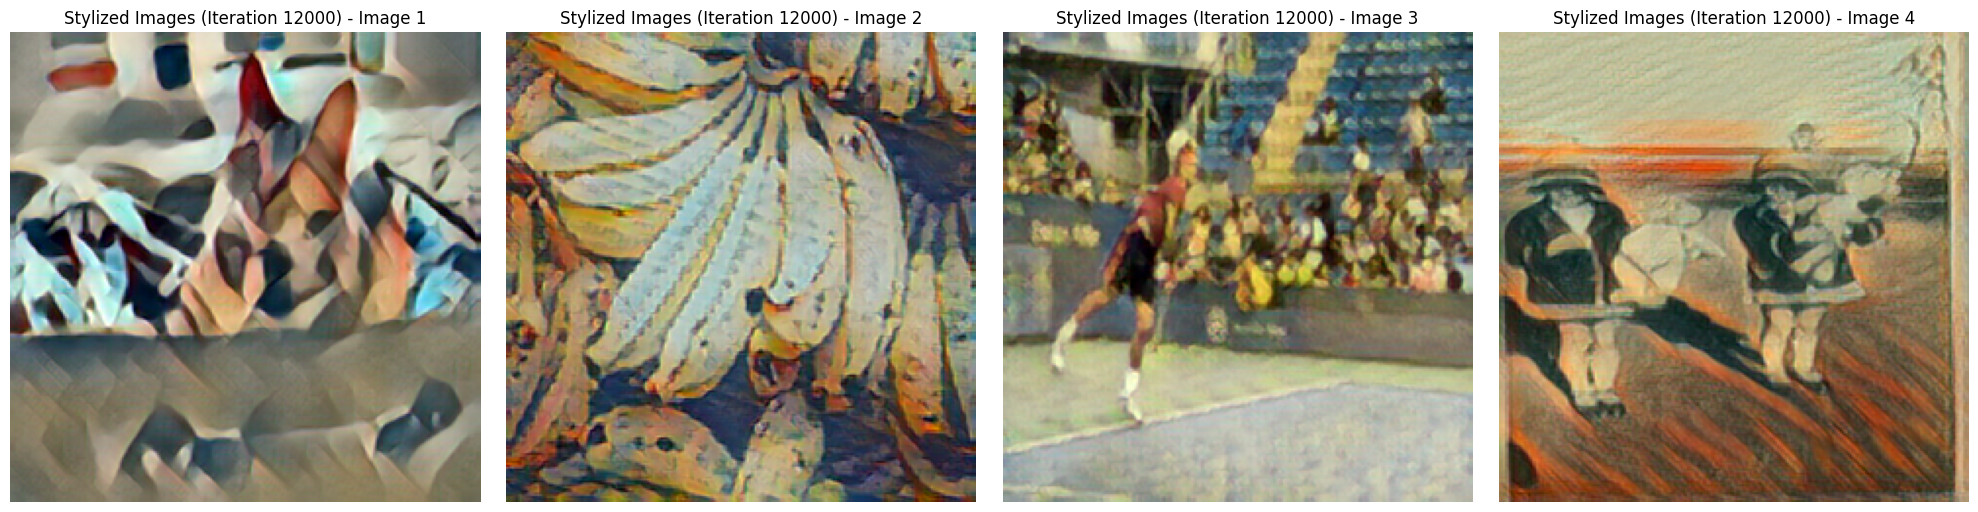

Training Progress:  50%|█████████████████                 | 12001/24000 [30:46<1:06:32,  3.01iter/s]

Model saved at iteration 12000


Training Progress:  54%|███████████████████▌                | 13001/24000 [35:11<24:16,  7.55iter/s]

iter.: 13000, content: 8.1868 (weighted), style: 7.5121 (weighted), tv: 0.00000026 (weighted), total: 15.6989 (weighted)


Training Progress:  58%|█████████████████████               | 14001/24000 [37:27<21:23,  7.79iter/s]

iter.: 14000, content: 12.8128 (weighted), style: 9.4087 (weighted), tv: 0.00000031 (weighted), total: 22.2215 (weighted)


Training Progress:  63%|██████████████████████▌             | 15001/24000 [40:43<20:45,  7.22iter/s]

iter.: 15000, content: 21.7740 (weighted), style: 24.3124 (weighted), tv: 0.00000040 (weighted), total: 46.0864 (weighted)


Training Progress:  67%|████████████████████████            | 16000/24000 [43:01<20:39,  6.45iter/s]

iter.: 16000, content: 14.5084 (weighted), style: 12.1582 (weighted), tv: 0.00000035 (weighted), total: 26.6666 (weighted)
Model saved at iteration 16000


Training Progress:  71%|█████████████████████████▌          | 17001/24000 [45:18<17:13,  6.77iter/s]

iter.: 17000, content: 12.1175 (weighted), style: 8.0104 (weighted), tv: 0.00000025 (weighted), total: 20.1279 (weighted)


Training Progress:  75%|███████████████████████████         | 18001/24000 [47:35<13:18,  7.52iter/s]

iter.: 18000, content: 11.1724 (weighted), style: 6.2909 (weighted), tv: 0.00000024 (weighted), total: 17.4633 (weighted)


Training Progress:  79%|████████████████████████████▌       | 19001/24000 [50:32<12:00,  6.94iter/s]

iter.: 19000, content: 11.8083 (weighted), style: 12.3343 (weighted), tv: 0.00000035 (weighted), total: 24.1425 (weighted)


Training Progress:  88%|███████████████████████████████▌    | 21000/24000 [58:19<16:02,  3.12iter/s]

iter.: 21000, content: 13.5739 (weighted), style: 10.4346 (weighted), tv: 0.00000042 (weighted), total: 24.0085 (weighted)


Training Progress:  92%|███████████████████████████████▏  | 22001/24000 [1:03:03<05:46,  5.76iter/s]

iter.: 22000, content: 14.9339 (weighted), style: 12.2164 (weighted), tv: 0.00000041 (weighted), total: 27.1504 (weighted)


Training Progress:  96%|████████████████████████████████▌ | 23001/24000 [1:06:55<03:21,  4.95iter/s]

iter.: 23000, content: 8.0632 (weighted), style: 6.0359 (weighted), tv: 0.00000030 (weighted), total: 14.0990 (weighted)


Training Progress: 100%|█████████████████████████████████▉| 23999/24000 [1:10:54<00:00,  3.86iter/s]

iter.: 24000, content: 8.0829 (weighted), style: 7.5042 (weighted), tv: 0.00000037 (weighted), total: 15.5871 (weighted)


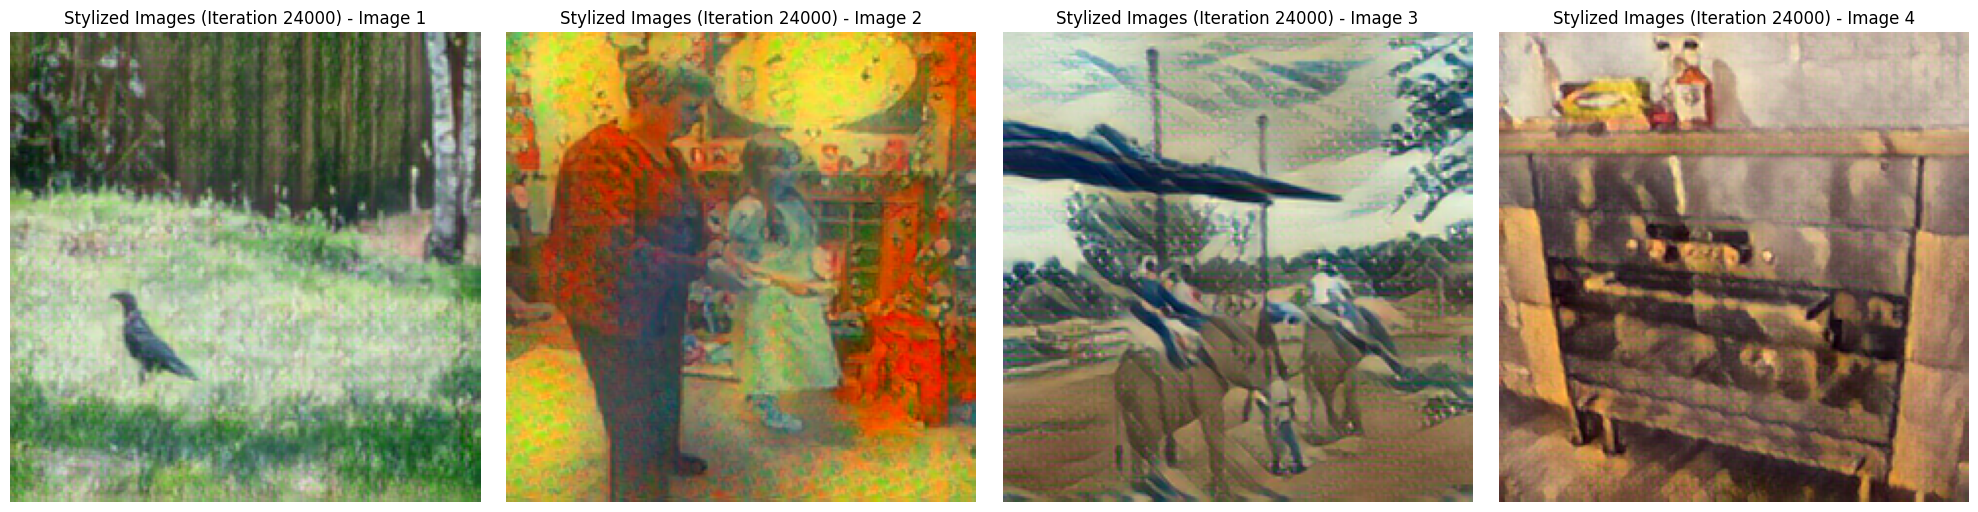

Training Progress: 100%|██████████████████████████████████| 24000/24000 [1:10:57<00:00,  5.64iter/s]

Model saved at iteration 24000


Final model saved at iteration 24000
Training completed in 4261.25 seconds (71.02 minutes / 1.18 hours)


In [ ]:
style_image_dir = '/workspace/s' 
content_image_dir = '/workspace/content' 
save_dir = '/workspace/dumoulin_v2'  

train_model_with_unseen_styles(style_image_dir, content_image_dir, save_dir, content_weight=1.0,
                                style_weight=10.0, tv_weight=1e-6,
                                learning_rate=1e-3, batch_size=4, num_iterations=24000,
                                save_interval=12000, save_model_interval=4000)


## Neural Style Transfer for Videos with Temporal Consistency

This code applies **Neural Style Transfer (NST)** to a video using a pretrained model that works with **unseen style images**. The model is based on **Adaptive Instance Normalization (ADAIN)**, which adapts the style from a given image to the content of the video frames. Temporal consistency is ensured by utilizing **optical flow**, which helps to maintain smooth transitions between consecutive frames. This approach does not require **style codes**, and instead, the path to the style image is directly passed to each frame for stylization.

### Key Components:

#### 1. **Video Stylization (`apply_nst_to_video`)**
The `apply_nst_to_video` function is the core of the process, where the **style transfer** is applied frame by frame:

**Style Image Loading**: The style image is loaded, resized, and center-cropped.

**Video Frame Extraction**: The input video (or GIF) is loaded using `imageio`, and each frame is extracted for processing.

**Resizing Frames**: The frames are resized to a specified target size while preserving the aspect ratio, preparing them for stylization.

**Frame Preprocessing**: Each frame is converted to a tensor and normalized using the model's required preprocessing steps.

**NST Application**: For each frame, the model is applied to transfer the style of the **style image** to the **content of the frame**.

**Temporal Consistency**: Optical flow between consecutive frames is computed using **Farneback's algorithm**. This flow is then used to warp the previous frame's stylized image, blending it with the current frame's stylization for a smoother transition.

**Frame Collection**: The stylized frames are collected and post-processed to restore their original visual characteristics.

#### 2. **Optical Flow (`cv2.calcOpticalFlowFarneback`)**
To ensure smooth transitions between frames:

**Optical Flow Calculation**: Optical flow is calculated between consecutive frames to detect pixel movement. This flow information is used to align and warp the previous frame’s stylized image with the current frame.

**Flow Map Generation**: The flow map is created by combining the calculated flow with the pixel grid of the current frame. This helps in aligning the previous frame’s stylized content with the current frame.

**Grid Sampling**: The `F.grid_sample` function from PyTorch is used to apply the warped flow map to the previous stylized frame, blending it with the current frame.

#### 3. **Frame Preprocessing (`get_resized_frame`, `preprocess_frame`, `postprocess_frame`)**
These functions handle the preparation of frames for NST:

**Resizing**: Frames are resized to the target size while maintaining the original aspect ratio.

**Preprocessing**: Each resized frame is converted into a tensor and normalized according to the model’s preprocessing requirements.

**Postprocessing**: After stylization, the frames are denormalized and clamped to ensure pixel values are within the valid range.

#### 4. **Model Loading**
The pretrained NST model is loaded:

**Model State**: The model weights are loaded from a checkpoint file, and the model is set to **evaluation mode** to ensure no updates occur during inference.

**Device Handling**: The model is moved to **GPU** (if available) for faster computation.

#### 5. **Video Writing (`cv2.VideoWriter`)**
Once all frames are processed:

**Video Writer Setup**: A `cv2.VideoWriter` is used to save the processed frames as a new video. The frames are written to the output video file with the specified **frames per second (FPS)**.

**Frame Dimensions**: The frame dimensions are automatically extracted from the first frame to ensure consistency across all frames in the video.

### Usage:
This code applies **style transfer** to videos by transforming each frame based on the style of a given style image. The key feature is its ability to maintain **temporal consistency** using optical flow, preventing flickering or abrupt changes between consecutive frames. The **stylized video** is saved to disk and can be viewed or further processed as needed.

The output is a **stylized video** that maintains the content of the original video while applying the artistic style from the provided style image, with smooth transitions between frames.


In [20]:
import torch.nn.functional as F

# Function for applying NST to a video
def apply_nst_to_video(video_path, style_image_path, output_video_path, model, device, target_size=256, fps=None):
    """
    Apply Neural Style Transfer (NST) to a video with temporal consistency.
    
    :param video_path: Path to the input video (supports GIF via imageio).
    :param style_image_path: Path to the style image.
    :param output_video_path: Path to save the output video.
    :param model: The pretrained NST model.
    :param device: Device (GPU or CPU).
    :param target_size: The long side size to which frames will be resized (preserving aspect ratio).
    :param fps: Frames per second for the output video (auto-detected if None).
    """
    # Load style image with training-like transforms (resize + center crop)
    style_image = load_image_from_path(style_image_path, image_size=256, crop_size=240, center_crop_flag=True)
    style_image = style_image.to(device)

    # Load video frames using imageio for better GIF support
    reader = imageio.get_reader(video_path)
    frames = [frame for frame in reader]
    meta = reader.get_meta_data()
    detected_fps = meta.get('fps', 30.0)  # Fallback to 30 if not found
    if fps is None:
        fps = detected_fps
    reader.close()

    # Get resized raw frames for optical flow (numpy RGB)
    resized_frames = [get_resized_frame(frame, target_size) for frame in frames]

    # Preprocess all frames to tensors for model
    processed_frames = [preprocess_frame(resized_frame) for resized_frame in resized_frames]

    # Apply NST to each frame with temporal consistency
    stylized_frames = []
    prev_stylized = None
    prev_resized = None

    for i, frame in enumerate(processed_frames):
        frame = frame.to(device)
        with torch.no_grad():
            stylized = model(frame, style_image)
        
        if prev_stylized is not None and prev_resized is not None:
            # Compute optical flow from prev_resized to current resized frame
            curr_resized = resized_frames[i]
            prev_gray = cv2.cvtColor(prev_resized, cv2.COLOR_RGB2GRAY)
            curr_gray = cv2.cvtColor(curr_resized, cv2.COLOR_RGB2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            # Create flow map
            h, w = flow.shape[:2]
            y, x = np.mgrid[0:h, 0:w]
            flow_map = np.stack((x, y), axis=-1).astype(np.float32)
            flow_map += flow
            flow_map[..., 0] = 2.0 * flow_map[..., 0] / max(w - 1, 1) - 1.0
            flow_map[..., 1] = 2.0 * flow_map[..., 1] / max(h - 1, 1) - 1.0
            
            # Convert to torch [1, H, W, 2]
            flow_map = torch.from_numpy(flow_map).unsqueeze(0).to(device).float()
            
            # Warp previous stylized frame
            prev_stylized_warped = F.grid_sample(prev_stylized, flow_map, mode='bilinear', padding_mode='border', align_corners=False)
            
            # Blend: 80% new stylized + 20% warped previous for smoothness
            stylized = 0.8 * stylized + 0.2 * prev_stylized_warped
        
        stylized_frames.append(stylized)
        prev_stylized = stylized.clone().detach()
        prev_resized = resized_frames[i]

    # Post-process the frames
    stylized_frames_processed = [postprocess_frame(frame) for frame in stylized_frames]

    # Convert to NumPy format for OpenCV
    stylized_frames_np = [convert_tensor_to_numpy(frame) for frame in stylized_frames_processed]

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_video_path), exist_ok=True)

    # Get frame dimensions from the first frame
    frame_height, frame_width = stylized_frames_np[0].shape[:2]

    # Define the video writer with codec and frame rate
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for MP4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Write each frame to the video
    for frame in stylized_frames_np:
        out.write(frame)

    out.release()
    print(f"Stylized video saved to {output_video_path}")

def get_resized_frame(frame, target_size=256):
    """
    Resize frame preserving aspect ratio, return numpy RGB.
    """
    frame = np.array(frame)  # Ensure numpy
    # Convert to RGB if needed
    if frame.ndim == 2:  # Grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    elif frame.shape[2] == 4:  # RGBA
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
    # Assume already RGB otherwise

    h, w = frame.shape[:2]
    if h > w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))
    return cv2.resize(frame, (new_w, new_h))

def preprocess_frame(resized_frame):
    """
    Convert resized numpy RGB to normalized tensor.
    """
    frame = T.ToTensor()(resized_frame).unsqueeze(0)
    frame = image_normalize(frame)
    return frame

def postprocess_frame(stylized_frame):
    """
    Denormalize and clamp the image values to the range [0, 1].
    """
    stylized_frame = image_denormalize(stylized_frame).clamp_(0.0, 1.0)
    return stylized_frame

def convert_tensor_to_numpy(stylized_frame):
    """
    Convert the stylized tensor to a NumPy array for saving as video frame (in BGR for OpenCV).
    """
    stylized_frame = stylized_frame.squeeze(0)  # Remove batch dimension
    stylized_frame = stylized_frame.cpu().detach().numpy()
    stylized_frame = np.transpose(stylized_frame, (1, 2, 0))
    stylized_frame = (stylized_frame * 255).astype(np.uint8)
    stylized_frame = cv2.cvtColor(stylized_frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
    return stylized_frame

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = ImageStyleTransferNet()
checkpoint = torch.load('/workspace/dumoulin_v2/model_cin_adain_12000.ckpt')
model.load_state_dict(checkpoint["state_dict"])
model.eval()  # Set the model to evaluation mode
model = model.to(device)  # Move to GPU if available

# Apply NST to a video
apply_nst_to_video(
    video_path='/workspace/video3.mp4',  # Path to the input video/GIF
    style_image_path='/workspace/s/style3(2).jpg',    # Path to the style image
    output_video_path='/workspace/video3_style3.mp4',  # Path to save the stylized video
    model=model,
    device=device,
    target_size=1024,  # Long side size (matches training)
    fps=None  # Auto-detect FPS
)

Stylized video saved to /workspace/video3_style3.mp4
